## LSTM - With RDA data representation approach *Geo-coordinate estimation 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
import math

import tensorflow as tf
from tensorflow.keras.models import load_model


In [3]:
to_store_path = r'D:\2 Thesis\2 models\2023.07.02 all models\LSTM_02\prediction csv\rrangle_rdist_lstm_output_45meter.csv'

In [4]:
X_test_path = r'D:\2 Thesis\1 train datasets\2 train rda\3 test\data_2019_12_X.npy'
X_test = np.load(X_test_path)

In [5]:
rangle_path = r'D:\2 Thesis\2 models\2023.07.02 all models\LSTM_02\prediction csv\v1_lstm_pred_output_rr_angle.csv'
rdist_path = r'D:\2 Thesis\2 models\2023.07.02 all models\LSTM_02\prediction csv\v1_lstm_pred_output_rel_dist.csv'
Y_test_lat_path = r'D:\2 Thesis\1 train datasets\2 train rda\3 test\data_2019_12_Y_lat.npy'
Y_test_lon_path = r'D:\2 Thesis\1 train datasets\2 train rda\3 test\data_2019_12_Y_lon.npy'

In [6]:
rangle_test_df = pd.read_csv(rangle_path)
rdist_test_df = pd.read_csv(rdist_path)

In [7]:
rangle_test_df = rangle_test_df.drop('Unnamed: 0', axis=1)
rdist_test_df = rdist_test_df.drop('Unnamed: 0', axis=1)

In [8]:
rangle_test_df['rangle_pred'] = rangle_test_df.apply(lambda row: math.degrees(math.atan2(row['sin_rangle_pred'], row['cos_rangle_pred'])), axis=1)
rangle_test_df['rangle'] = rangle_test_df.apply(lambda row: math.degrees(math.atan2(row['sin_rangle'], row['cos_rangle'])), axis=1)

In [10]:
(abs(rangle_test_df['rangle_pred']-rangle_test_df['rangle'])).median()

1.9799789652546793

In [12]:
Y_test_df = pd.concat([rangle_test_df, rdist_test_df], axis=1)
X_test_flat = X_test.flatten()
# reshape to 2D array with 8 columns
X_test_array = X_test_flat.reshape(-1, 8)
# convert to pandas dataframe
X_test_df = pd.DataFrame(X_test_array, columns=['lat_s', 'lon_s', 'sog_s', 'cog_sin', 'cog_cos', 'ndc_s', 'in_tss', 'TSS_Vessel'])

In [14]:
# converting back to lat long degrees

min_lat, max_lat = 58.6, 59.93
min_lon, max_lon = 9.4, 11.45

# Y_pred_df['lat_pred'] = Y_pred_df['lat_s_pred'] * (max_lat - min_lat) + min_lat
# Y_pred_df['lon_pred'] = Y_pred_df['lon_s_pred'] * (max_lon - min_lon) + min_lon

# Y_test_df['lat_test'] = Y_test_df['lat_s_test'] * (max_lat - min_lat) + min_lat
# Y_test_df['lon_test'] = Y_test_df['lon_s_test'] * (max_lon - min_lon) + min_lon

X_test_df['lat'] = X_test_df['lat_s'] * (max_lat - min_lat) + min_lat
X_test_df['lon'] = X_test_df['lon_s'] * (max_lon - min_lon) + min_lon
X_test_df['voyage_id'] = X_test_df.index // 10
X_test_df['step'] = np.arange(len(X_test_df)) % 10


In [15]:
X_test_df['cog'] = np.degrees(np.arctan2(X_test_df['cog_sin'], X_test_df['cog_cos']))

In [17]:
Y_test_df['lat_ref'] = 0
Y_test_df['lon_ref'] = 0
Y_test_df['cog_ref'] = 0

start_indices = np.arange(0, len(Y_test_df), 10)
end_indices = start_indices + 9

lat_val = X_test_df['lat'].values[end_indices]
lon_val = X_test_df['lon'].values[end_indices]
cog_val = X_test_df['cog'].values[end_indices]


lat_rep = np.repeat(lat_val, 10)
lon_rep = np.repeat(lon_val, 10)
cog_rep = np.repeat(cog_val, 10)

Y_test_df['lat_ref'] = lat_rep[:len(Y_test_df)]
Y_test_df['lon_ref'] = lon_rep[:len(Y_test_df)]
Y_test_df['cog_ref'] = cog_rep[:len(Y_test_df)]

In [19]:
(abs((Y_test_df['rel_dist_pred']) - Y_test_df['rel_dist'])).mean()

48.106779892367356

In [20]:
(abs(Y_test_df['rangle_pred'] - Y_test_df['rangle'])).mean()

7.175273540673978

In [22]:
Y_test_df['angle_pred'] = Y_test_df['cog_ref'] - Y_test_df['rangle_pred']

In [24]:
Y_test_df['lat2'] = 0
Y_test_df['lon2'] = 0


In [26]:
import numpy as np
import pandas as pd

def reverse_haversine(df):
    R = 6378.137  # Radius of Earth in km
    
    lat1 = np.radians(df['lat_ref'].values)
    lon1 = np.radians(df['lon_ref'].values)
    bearing = np.radians(df['angle_pred'].values)
    distance = df['rel_dist_pred'].values/1000
    
    angdist = distance / R
    
    lat2 = np.degrees(np.arcsin((np.sin(lat1) * np.cos(angdist)) + (np.cos(lat1) * np.sin(angdist) * np.cos(bearing))))
    lon2 = np.degrees(lon1 + np.arctan2((np.sin(bearing) * np.sin(angdist) * np.cos(lat1)), (np.cos(angdist) - (np.sin(lat1) * np.sin(np.radians(lat2))))))
    
    df['lat2'] = lat2
    df['lon2'] = lon2
    
    return df

Y_test_df= reverse_haversine(Y_test_df)

In [29]:
Y_test_df.to_csv(to_store_path)

In [30]:
Y_test_lat = np.load(Y_test_lat_path)
Y_test_lon = np.load(Y_test_lon_path)

In [31]:
Y_test_lat_flat = Y_test_lat.flatten()
Y_test_lat_df = pd.DataFrame(Y_test_lat_flat, columns=['lat_s_test'])

Y_test_lon_flat = Y_test_lon.flatten()
Y_test_lon_df = pd.DataFrame(Y_test_lon_flat, columns=['lon_s_test'])

# Concatnating the lat lon test data - to on df
Y_test_and_pred_df = pd.concat([Y_test_lat_df, Y_test_lon_df, Y_test_df], axis=1)

In [32]:
# converting back to lat long degrees

min_lat, max_lat = 58.6, 59.93
min_lon, max_lon = 9.4, 11.45

Y_test_and_pred_df['lat_test'] = Y_test_and_pred_df['lat_s_test'] * (max_lat - min_lat) + min_lat
Y_test_and_pred_df['lon_test'] = Y_test_and_pred_df['lon_s_test'] * (max_lon - min_lon) + min_lon


In [34]:
from haversine import haversine, Unit

Y_test_and_pred_df['deviation_dist_m'] = Y_test_and_pred_df.apply(lambda row: haversine(
    (row['lat2'], 
    row['lon2']),
    (row['lat_test'], 
    row['lon_test']),
    unit=Unit.METERS
    ),axis=1)

In [35]:
mean_deviation = Y_test_and_pred_df['deviation_dist_m'].mean()
median_deviation = Y_test_and_pred_df['deviation_dist_m'].median()

print('LSTM_model mean_displacement_error:', mean_deviation)
print('LSTM_model median_displacement_error:', median_deviation)

LSTM_model mean_displacement_error: 99.81248583630021
LSTM_model median_displacement_error: 39.325283307633995


In [36]:
step_means = []
for step in range(10):
    step_mean = Y_test_and_pred_df['deviation_dist_m'][step::9].mean()
    step_means.append(step_mean)


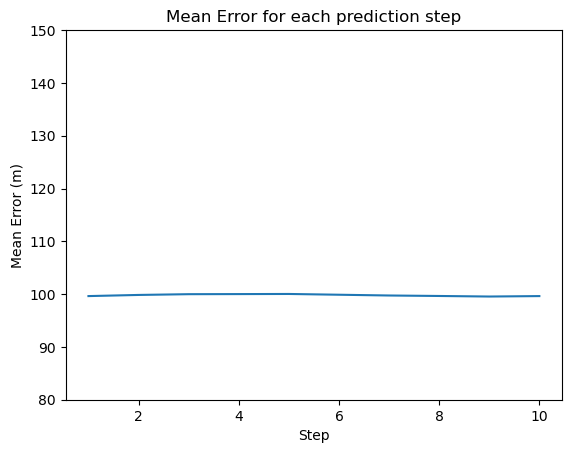

In [47]:
import matplotlib.pyplot as plt

plt.plot(range(1, 11), step_means)
plt.xlabel('Step')
plt.ylabel('Mean Error (m)')
plt.title('Mean Error for each prediction step')
plt.ylim(0, 150)
plt.show()


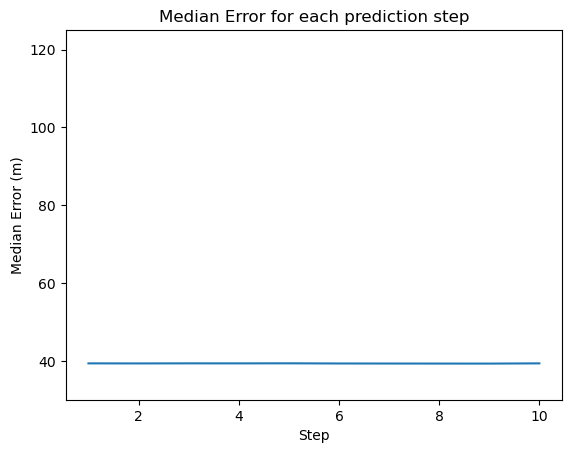

In [48]:
import matplotlib.pyplot as plt

step_medians = []
for step in range(10):
    step_median = Y_test_and_pred_df['deviation_dist_m'][step::9].median()
    step_medians.append(step_median)

plt.plot(range(1, 11), step_medians)
plt.xlabel('Step')
plt.ylabel('Median Error (m)')
plt.title('Median Error for each prediction step')
plt.ylim(00,125)
plt.show()


In [39]:

step_FDE = Y_test_and_pred_df['deviation_dist_m'][9::9].mean()
print('Final displacement error (meters) is:', step_FDE)

Final displacement error (meters) is: 99.62799250194112


In [40]:
Y_test_and_pred_df['voyage_id'] = Y_test_and_pred_df.index // 10
Y_test_and_pred_df['step'] = np.arange(len(Y_test_and_pred_df)) % 10


In [41]:
Y_test_and_pred_df.to_csv(to_store_path)
